In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shivamb_go_emotions_google_emotions_dataset_path = kagglehub.dataset_download('shivamb/go-emotions-google-emotions-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data Visualization**

In [ ]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
import plotly.express as px
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/shivamb/go-emotions-google-emotions-dataset/versions/1/go_emotions_dataset.csv")

In [ ]:
df.head()

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df= df[df['example_very_unclear'] == False]
df.drop('id', inplace=True, axis=1)
df.drop('example_very_unclear', inplace=True, axis=1)

In [ ]:
df1 =df.iloc[:,1:]

<Axes: >

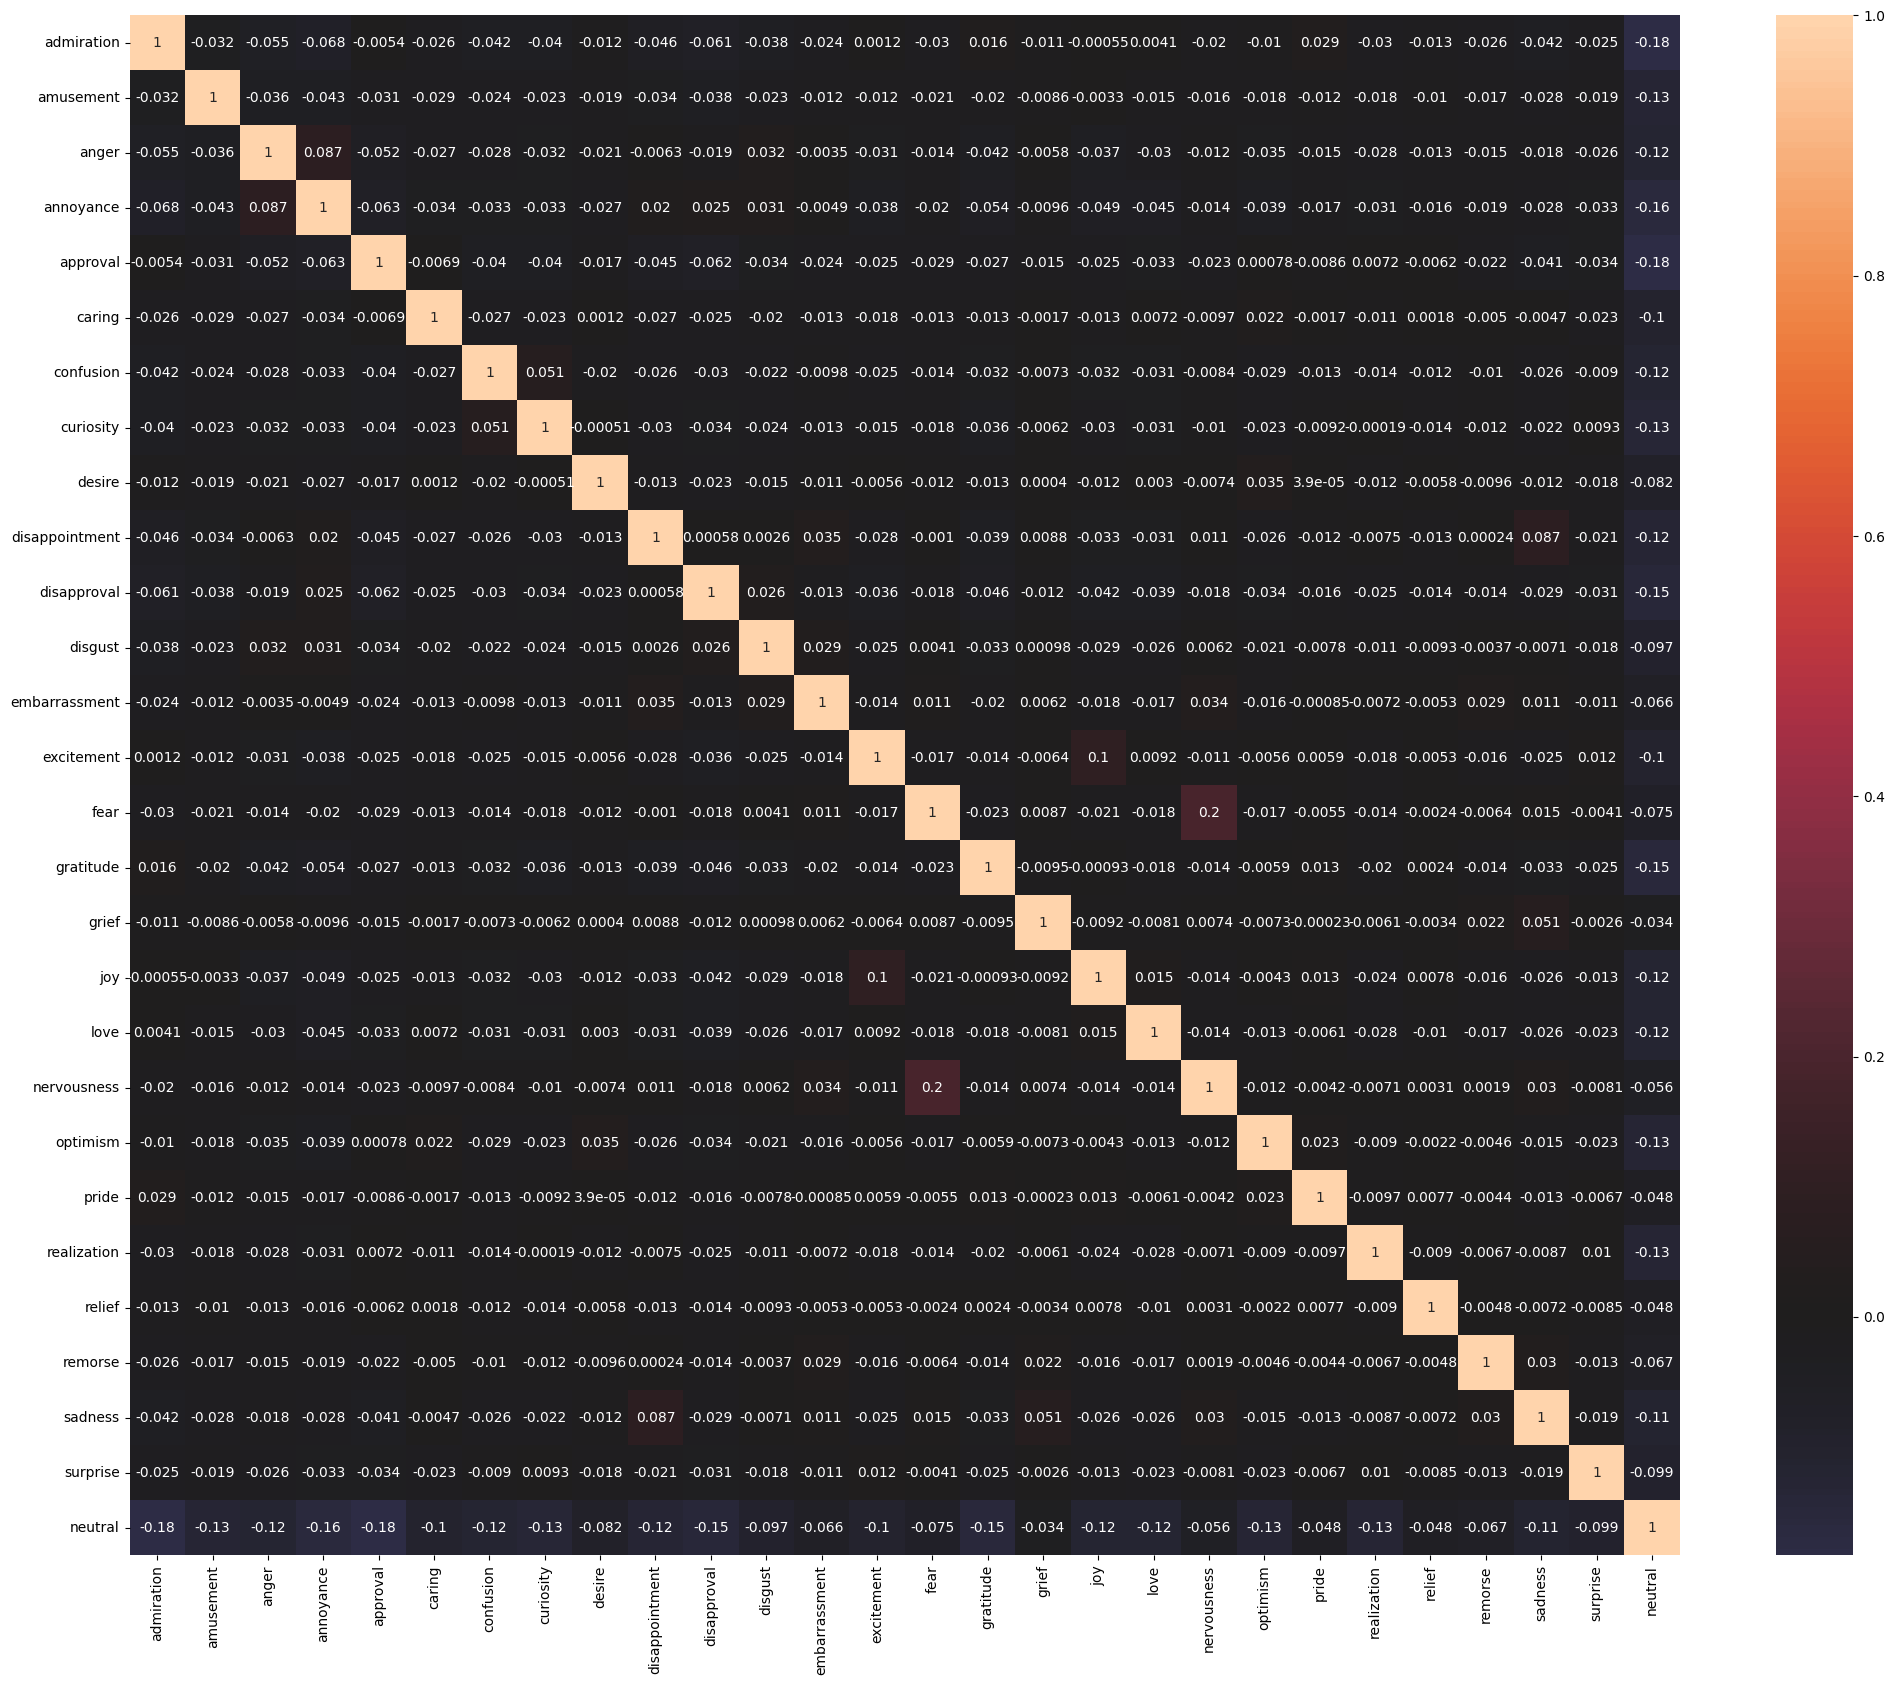

In [ ]:
plt.figure(figsize=(25,20))
sns.heatmap(df1.corr(), center=0, annot=True)

In [ ]:
emotions = set(df.columns[1:])
positive = ['admiration', 'amusement', 'approval', 'excitement', 'gratitude', 'joy', 'love', 'pride', 'relief', 'optimism', 'desire','caring']
negative = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']
neutral = ['neutral']
mixed= ['confusion', 'surprise', 'curiosity','realization']


In [ ]:
df_emotion = pd.DataFrame()
df_emotion["text"] = df["text"]
df_emotion['emotion'] = df.iloc[:, 1:].idxmax(axis=1)
df_emotion['group'] = ''
df_emotion.loc[df_emotion['emotion'].isin(positive), 'group'] = 'positive'
df_emotion.loc[df_emotion['emotion'].isin(negative), 'group'] = 'negative'
df_emotion.loc[df_emotion['emotion'].isin(neutral), 'group'] = 'neutral'
df_emotion.loc[df_emotion['emotion'].isin(mixed), 'group'] = 'mixed'

In [ ]:
df_emotion.describe()

,text,emotion,group
count,207814,207814,207814
unique,57730,28,4
top,Thank you.,neutral,positive
freq,45,55298,79436


In [ ]:
df_emotion.drop_duplicates(subset="text",keep="first",inplace=True,ignore_index=True)

In [ ]:
df_emotion.describe()

,text,emotion,group
count,57730,57730,57730
unique,57730,28,4
top,That game hurt.,neutral,positive
freq,1,15803,22347


In [ ]:
df_emotion["group"].value_counts()

,count
group,
positive,22347
neutral,15803
negative,13249
mixed,6331


<Axes: xlabel='n', ylabel='emotion'>

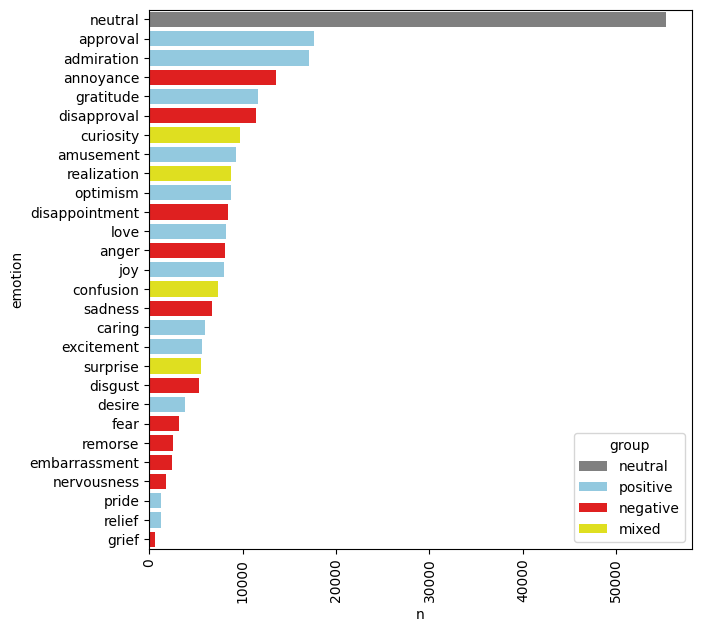

In [ ]:
temp = df[list(emotions)].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .merge(df_emotion, how='left', on='emotion')\
    .sort_values('n', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
palette ={
    "positive": "skyblue",
    "negative": "red",
    "neutral": 'gray',
    "mixed": 'yellow'
}
sns.barplot(data=temp, x='n',
            y='emotion', hue='group',
            dodge=False,
            palette=palette,
            ax=ax)

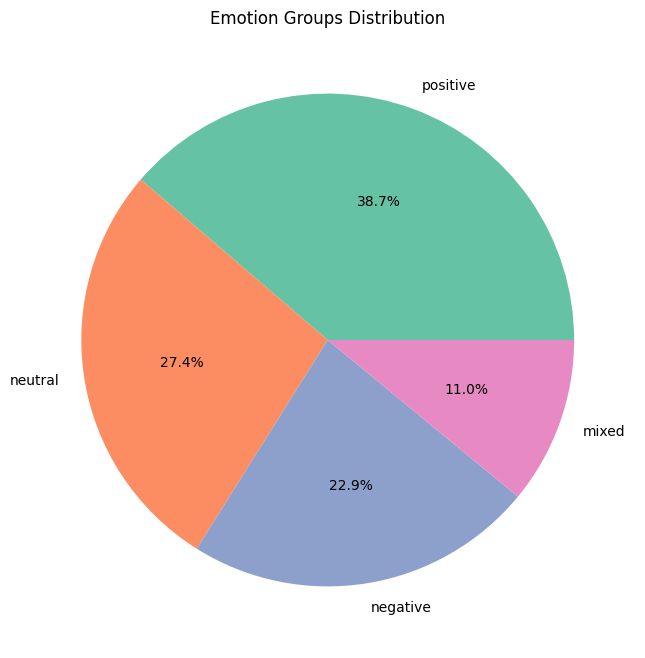

In [ ]:
group_counts = df_emotion['group'].value_counts()
# Pie Chart oluşturma
plt.figure(figsize=(8, 8))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("Emotion Groups Distribution")
plt.show()


In [ ]:
!pip install emoji
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

df_emotion["text"] = df_emotion["text"].apply(remove_emojis)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 16.0 MB/s eta 0:00:00


In [ ]:
df_emotion['words'] = [len(x.split()) for x in df_emotion['text'].tolist()]

In [ ]:
df_emotion

,text,emotion,group,words
0,That game hurt.,sadness,negative,3
1,"You do right, if you don't care then fuck 'em!",neutral,neutral,10
2,Man I love reddit.,love,positive,4
3,"[NAME] was nowhere near them, he was by the Fa...",neutral,neutral,10
4,Right? Considering it’s such an important docu...,gratitude,positive,21
...,...,...,...,...
57725,I didn’t even notice that one. I noticed the b...,neutral,neutral,12
57726,"Thanks, [NAME]",gratitude,positive,2
57727,Everyone likes [NAME].,love,positive,3
57728,Projecting pretty hard here.,neutral,neutral,4


# **Data Reducing**

In [ ]:
df_emotion['words'].describe()

,words
count,57730.000000
mean,12.941348
std,6.670859
min,0.000000
25%,7.000000
50%,12.000000
75%,18.000000
max,33.000000


In [ ]:
df_emotion = df_emotion[~(df_emotion["words"] == 0)]

In [ ]:
df_emotion.groupby(['group'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
mixed,6331.0,13.511452,6.372828,1.0,8.0,13.0,18.0,30.0
negative,13249.0,13.514680,6.626597,1.0,8.0,13.0,19.0,31.0
neutral,15802.0,12.563979,6.828316,1.0,7.0,12.0,18.0,32.0
positive,22347.0,12.707343,6.633668,1.0,7.0,12.0,18.0,33.0


In [ ]:

"""min_samples_per_class = df_emotion['group'].value_counts().min()

# Her sınıftan eşit sayıda örnek seçme
dff = df_emotion.groupby('group').apply(lambda x: x.sample(min_samples_per_class, random_state=42)).reset_index(drop=True)

print(dff['group'].value_counts())"""
dff = df_emotion

# **Data Preprocessing**

In [ ]:
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'll": "how will", "how's": "how is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not",
    "shan't": "shall not", "sha'n't": "shall not", "she'd": "she would", "she'll": "she will",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "that'd": "that would",
    "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
    "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have",
    "where'd": "where did", "where's": "where is", "who'll": "who will", "who's": "who is",
    "won't": "will not", "wouldn’t": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "gonna": "going to", "wanna": "want to", "gotta": "got to", "lemme": "let me", "gimme": "give me", "youre" : "you are"
}

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stops = set(stopwords.words("english"))
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
lemmatizer = WordNetLemmatizer()
def clean_text(text,remove_stopwords = True):
    text = re.sub(r'\[NAME\]', '', text)
    text = text.lower()
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            word = word.replace("’", "'")
            new_text.append(word)

    text = " ".join(new_text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\d+', '', text)
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text )
    return text
def clean_and_lemmatize(text):
    text = clean_text(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
dff["cleaned_text"] = dff['text'].apply(clean_and_lemmatize)

<ipython-input-26-88006c42fe6e>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["cleaned_text"] = dff['text'].apply(clean_and_lemmatize)


In [ ]:
dff["text"]

,text
0,That game hurt.
1,"You do right, if you don't care then fuck 'em!"
2,Man I love reddit.
3,"[NAME] was nowhere near them, he was by the Fa..."
4,Right? Considering it’s such an important docu...
...,...
57725,I didn’t even notice that one. I noticed the b...
57726,"Thanks, [NAME]"
57727,Everyone likes [NAME].
57728,Projecting pretty hard here.


In [ ]:
dff["cleaned_text"]

,cleaned_text
0,game hurt
1,right care fuck em
2,man love reddit
3,nowhere near falcon
4,right considering important document know damn...
...,...
57725,even notice one noticed bottom right one
57726,thanks
57727,everyone like
57728,projecting pretty hard


In [ ]:
dff['group'].value_counts()

,count
group,
positive,22347
neutral,15802
negative,13249
mixed,6331


In [ ]:
from sklearn.utils import resample

min_samples = dff['group'].value_counts().min()

downsampled_dfs = []
for label in dff['group'].unique():
    class_df = dff[dff['group'] == label]
    downsampled = resample(class_df, replace=False, n_samples=min_samples, random_state=42)
    downsampled_dfs.append(downsampled)

balanced_df = pd.concat(downsampled_dfs)

dff=balanced_df


In [ ]:

new_df = dff[["text", "group"]]


In [ ]:
new_df

,text,group
25642,Damn this kid and her fancy clothes makes me f...,negative
35884,Really not sure how that’s your takeaway.,negative
27229,Growing up there were people in our church who...,negative
21932,I’m not high and that sounds like a good sandw...,negative
42101,"Even if I did, no one would believe me....,",negative
...,...,...
33546,Confused and triggered,mixed
46971,He seems to think that will take too long. I g...,mixed
47314,Wow [NAME] retained NO combat skills from the ...,mixed
48661,It wasn't any better 10 years ago if that offe...,mixed


In [ ]:
new_df.to_csv("GoEmo.csv")

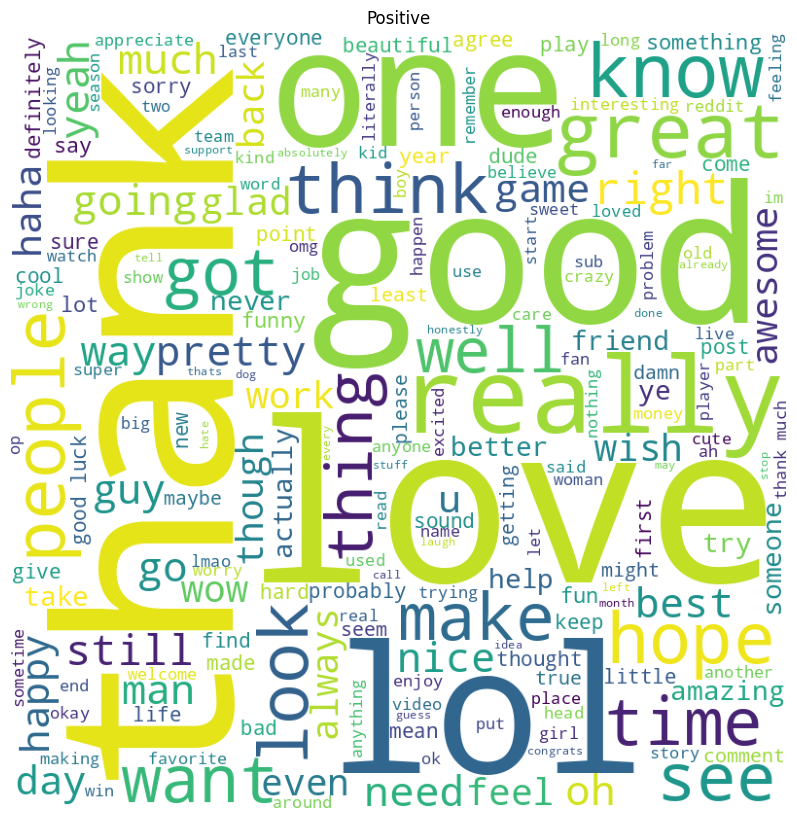

In [ ]:
selected_category = "positive"
selected_texts = dff[dff['group'] == selected_category]['cleaned_text']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Positive')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

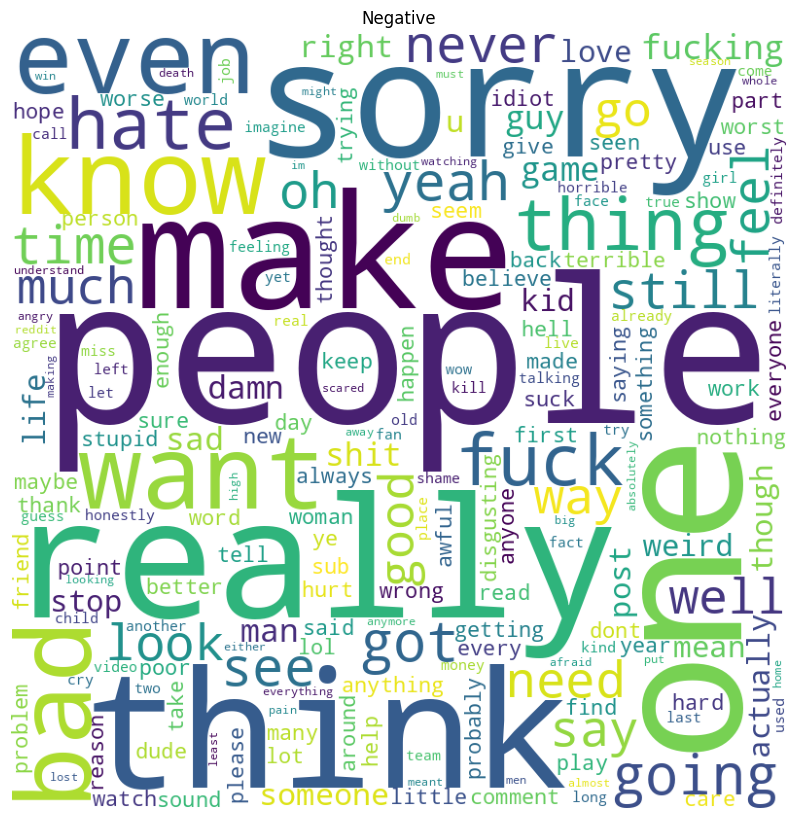

In [ ]:
selected_category = "negative"
selected_texts = dff[dff['group'] == selected_category]['cleaned_text']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Negative')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

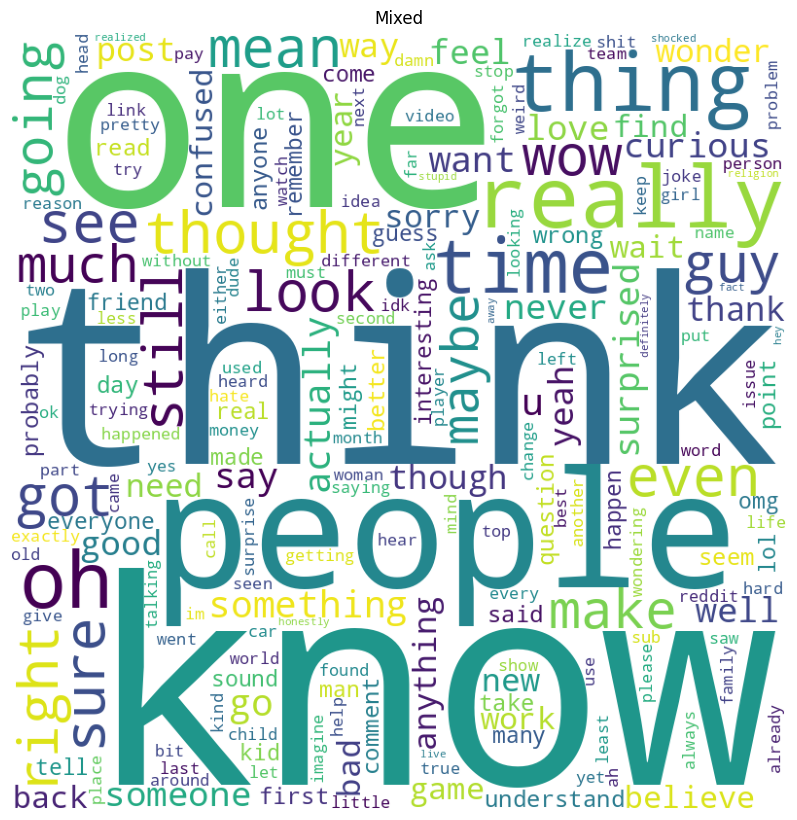

In [ ]:
selected_category = "mixed"
selected_texts = dff[dff['group'] == selected_category]['cleaned_text']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Mixed')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

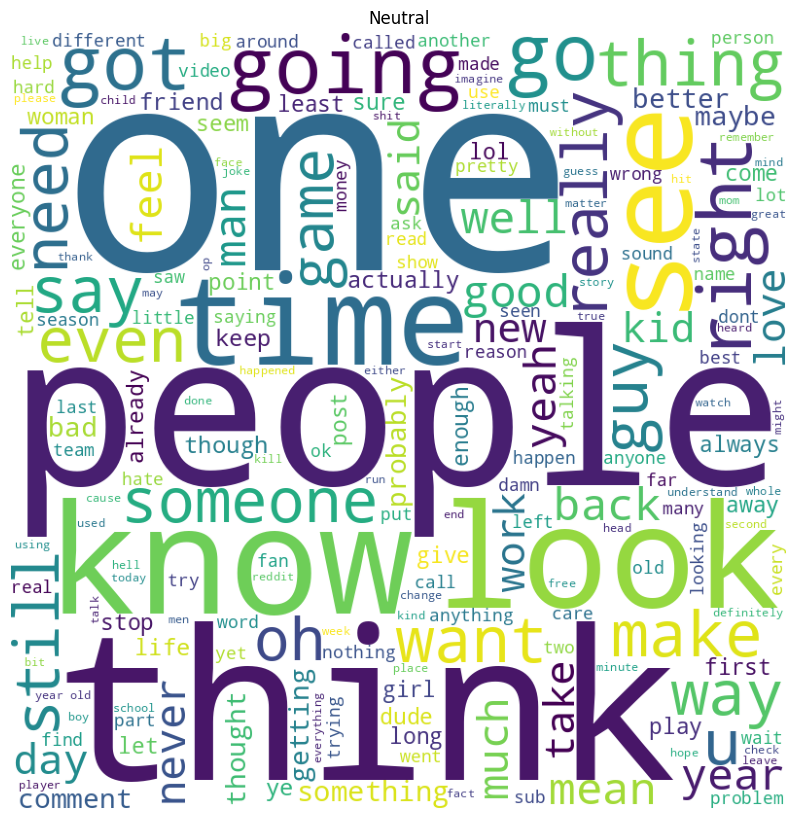

In [ ]:
selected_category = "neutral"
selected_texts = dff[dff['group'] == selected_category]['cleaned_text']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Neutral')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# **Feature Exctracting**

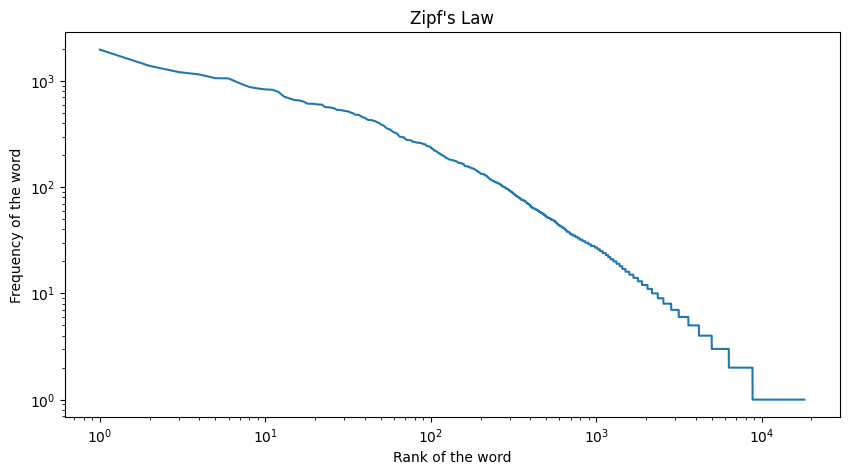

In [ ]:
from collections import Counter

word_counts = Counter(" ".join(dff['cleaned_text']).split())
word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# Zipf's Law grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(word_freq) + 1), word_freq['freq'])
plt.yscale('log')
plt.xscale('log')
plt.title("Zipf's Law")
plt.xlabel("Rank of the word")
plt.ylabel("Frequency of the word")
plt.show()


In [ ]:
news_dict={'negative':0,'neutral':1,'positive':2,'mixed':3}
dff["group"]=dff["group"].map(news_dict)

In [ ]:
from sklearn.model_selection import train_test_split

X = dff["cleaned_text"]
y = dff['group']


# **BERT Model**

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification,BertConfig
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import pandas as pd

train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.15, random_state=101)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_labels = torch.tensor(train_labels.values if isinstance(train_labels, pd.Series) else train_labels)
test_labels = torch.tensor(test_labels.values if isinstance(test_labels, pd.Series) else test_labels)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased',
                                    num_labels=4,
                                    hidden_dropout_prob=0.3)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import AdamW
from sklearn.metrics import accuracy_score
from transformers import get_scheduler


patience = 4
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
optimizer = AdamW(model.parameters(), lr=1e-5)
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


best_val_loss = float('inf')
patience_counter = 0

def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).sum().item() / len(labels)

for epoch in range(num_epochs):
    model.train()
    total_loss, train_acc = 0, 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        train_acc += calculate_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)


    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()
            val_acc += calculate_accuracy(outputs.logits, labels)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = val_acc / len(test_loader)


    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved!")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break




Epoch [1/10] - Train Loss: 1.1116, Train Acc: 0.5282
Epoch [1/10] - Val Loss: 1.1524, Val Acc: 0.5102
Best model saved!
Epoch [2/10] - Train Loss: 1.1017, Train Acc: 0.5363
Epoch [2/10] - Val Loss: 1.1469, Val Acc: 0.5094
Best model saved!
Epoch [3/10] - Train Loss: 1.0643, Train Acc: 0.5506
Epoch [3/10] - Val Loss: 1.1591, Val Acc: 0.5105
Epoch [4/10] - Train Loss: 1.0374, Train Acc: 0.5664
Epoch [4/10] - Val Loss: 1.1685, Val Acc: 0.5115
Epoch [5/10] - Train Loss: 1.0106, Train Acc: 0.5803
Epoch [5/10] - Val Loss: 1.2372, Val Acc: 0.5057
Epoch [6/10] - Train Loss: 0.9826, Train Acc: 0.5960
Epoch [6/10] - Val Loss: 1.2325, Val Acc: 0.5068
Early stopping triggered.


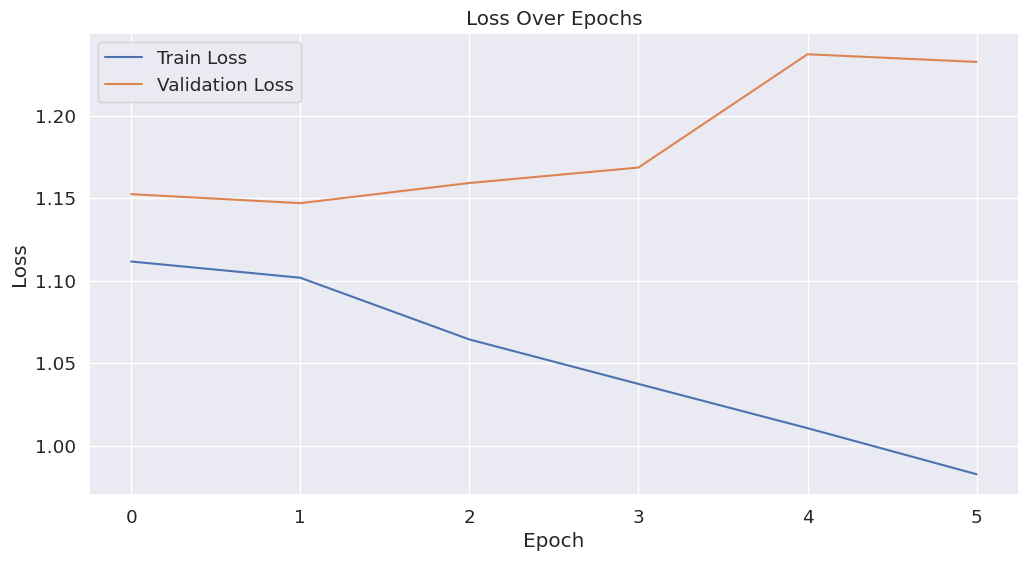

In [ ]:
# Loss Grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()



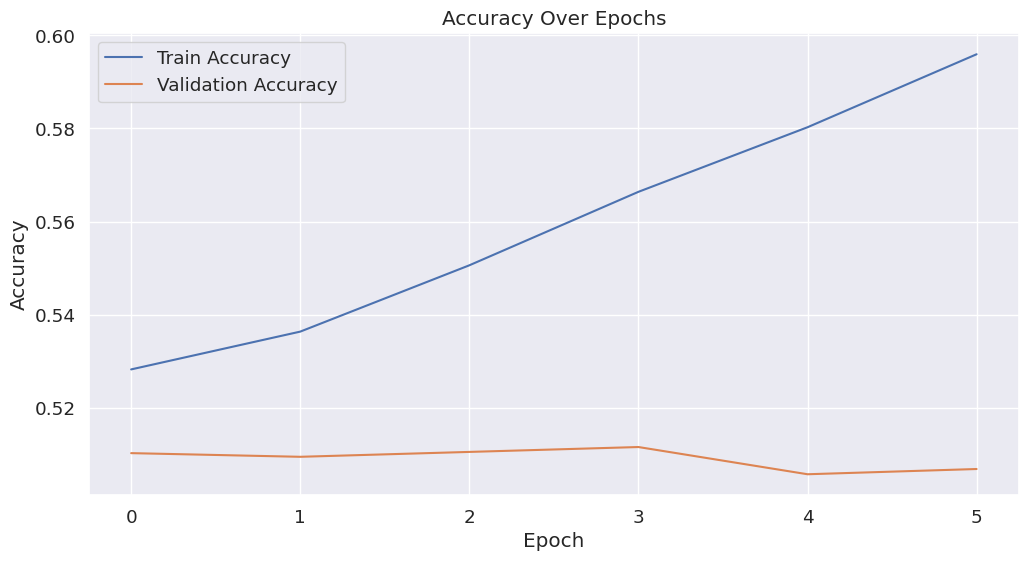

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

In [ ]:
report = classification_report(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.54       947
           1       0.46      0.26      0.33       988
           2       0.60      0.66      0.63       922
           3       0.45      0.55      0.49       942

    accuracy                           0.51      3799
   macro avg       0.50      0.51      0.50      3799
weighted avg       0.50      0.51      0.50      3799



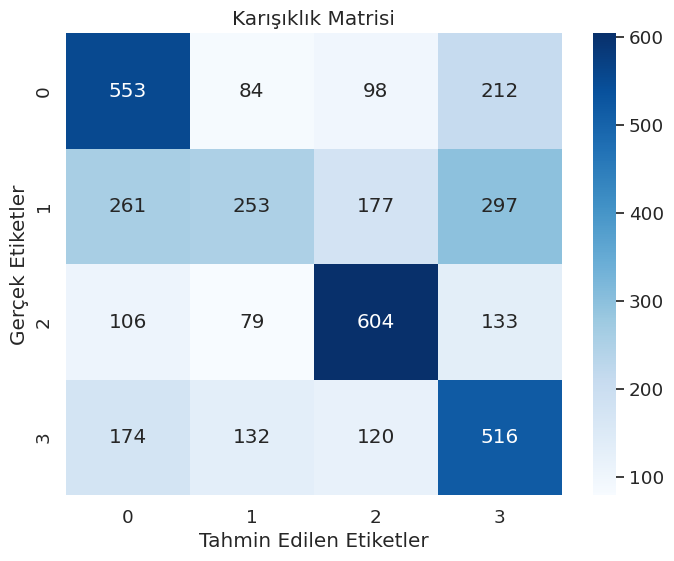

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Tahmin Edilen Etiketler")
    plt.ylabel("Gerçek Etiketler")
    plt.title("Karışıklık Matrisi")
    plt.show()
classes = [str(i) for i in range(len(cm))]

plot_confusion_matrix(cm, classes)

In [ ]:
torch.save(model, "bertModel.pth")
